In [46]:
from pearce.emulator.emu import OriginalRecipe, ExtraCrispy
from pearce.emulator.trainingData import parameter, PARAMS

In [47]:
from george.kernels import ExpSquaredKernel
import george

In [48]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from itertools import cycle
colors = cycle(sns.color_palette())

In [49]:
training_dir = '/u/ki/swmclau2/des/PearceLHC/'

In [50]:
or_params = PARAMS[:]
or_params.append(parameter('r', 0, 1)) #95% sure bounds aren't used for r
emu = OriginalRecipe(training_dir,or_params)

In [51]:
ig = emu.get_initial_guess('xi', {})
a = ig['amp']
kernel = a * ExpSquaredKernel(emu.metric, ndim=emu.emulator_ndim)
loo_gp = george.GP(kernel)
# gp = george.GP(kernel, solver=george.HODLRSolver, nleaf=x.shape[0]+1,tol=1e-18)

loo_gp.compute(emu.x[1:], emu.yerr[1:])  # NOTE I'm using a modified version of george!

In [52]:
K_inv_full = emu.gp.solver.apply_inverse(np.eye(emu.x.shape[0]),in_place=True)

In [53]:
y_param = 'logMmin'
emulation_point = [('f_c', 0.233), ('logM0', 12.0), ('sigma_logM', 0.533), 
                   ('alpha', 1.083),('logM1', 13.5), ('logMmin', 12.233)]
em_params = dict(emulation_point)
del em_params[y_param]

In [54]:
rbins = np.array([  0.06309573,   0.12437607,   0.24517359,   0.34422476, 0.48329302, 0.67854546,\
           0.9526807 , 1.33756775,1.8779508 ,   2.6366509 ,   3.70186906,   5.19743987, 7.29722764, \
           10.24533859,  14.38449888,  20.1958975 , 28.35512583,  39.81071706] )
rpoints= np.log10((rbins[1:]+rbins[:-1])/2)
em_params['r'] = rpoints[:2]

In [55]:
y_param_idx = -1
for idx, p in enumerate(PARAMS):
    if p.name==y_param:
        y_param_idx = idx
        break
        
y_vals = np.linspace(PARAMS[y_param_idx].low, PARAMS[y_param_idx].high, 4)
em_params[y_param] = y_vals

In [56]:
input_params = {}
input_params.update(em_params)

# i'd like to remove 'r'. possibly requiring a passed in param?
t_list = [input_params[p.name] for p in emu.ordered_params]
t_grid = np.meshgrid(*t_list)
t = np.stack(t_grid).T
t = t.reshape((-1, emu.emulator_ndim))
t = np.sort(t.view(','.join(['float64' for _ in xrange(min(t.shape))])),
            order=['f%d' % i for i in xrange(min(t.shape))], axis=0).view(np.float)

In [57]:
loo_mu = loo_gp.predict(emu.y[1:], t , mean_only=True)
print loo_mu

[ 2.7118659   2.10922335  2.90099548  2.4533758   3.33485557  2.9304436
  3.48463452  3.20825562]


In [58]:
loo_inv = loo_gp.solver.apply_inverse(np.eye(emu.x.shape[0]-1),in_place=True)
print loo_inv.shape, K_inv_full.shape

(8431, 8431) (8432, 8432)


In [59]:
print loo_inv[0,:]
print 
print loo_inv[1,:]

[  1.96564257e+02  -2.74440036e+02  -4.17402233e+01 ...,   4.86810266e-03
   4.65590985e-03  -4.36067291e-03]

[ -2.74440036e+02   7.61615949e+02   6.14895863e+01 ...,  -1.88435473e-02
  -2.50623516e-02   2.21037310e-02]


In [60]:
print K_inv_full[0,:]
print 
print K_inv_full[1,:]

[  1.07207315e+02  -7.49339987e+01   1.00697096e+02 ...,   1.87325557e-02
  -4.71164214e-03  -3.16211120e-04]

[ -7.49339987e+01   2.81840050e+02  -4.42344406e+02 ...,  -9.56717340e-02
   2.47047181e-02   1.04994773e-03]


In [61]:
mu, _ = emu.emulate(em_params)
print mu

[ 2.82404214  2.1429887   2.95890881  2.45252086  3.33484726  2.92748791
  3.49523175  3.21356925]


In [62]:
yhat = loo_gp.predict(emu.y[1:], emu.x[0].reshape((1,emu.x.shape[1])), mean_only=True)
print yhat

[ 3.81843655]


In [63]:
print emu.y[0]

3.72177668084


In [64]:
x, y = emu.x[:], emu.y[:]

N = K_inv_full.shape[0]
mus = np.zeros((N, t.shape[0]))

In [65]:
from time import time
from scipy.linalg import inv

In [66]:
my_inds = [i for i in xrange(1, N-1)]
my_inds.append(0)
my_inds = np.array(my_inds)

In [67]:
from copy import deepcopy

In [68]:
for idx in xrange(N):
    #print idx
    '''
    t0 = time()
    # This operation was really slow. Trying something else.
    # K_inv_idx_N = np.dot(rotation_matrix, np.dot(K_inv_full, rotation_matrix))
    # Small
    K_inv_full[[idx, N - 1], :] = K_inv_full[[N - 1, idx], :]
    K_inv_full[:, [idx, N - 1]] = K_inv_full[:, [N - 1, idx]]
    #print time() - t0, 's'
    # swap x and y as well
    x[[idx, N - 1], :] = x[[N - 1, idx], :]
    y[[idx, N - 1]] = y[[N - 1, idx]]

    K_inv_m_idx = K_inv_full[:N - 1, :][:,
          :N - 1]  # -np.outer(K_inv_full[N-1,:N-1], K_inv_full[:N-1,N-1])/K_inv_full[N-1,N-1]
    c = K_inv_full[N - 1, :N - 1]
    # The subtracction takes a long time
    K_inv_m_idx -= np.outer(c / K_inv_full[N - 1, N - 1], c)
    Kxxs = emu.gp.kernel.value(t, x[:N - 1])
    #print time() - t0, 's'  # slow-ish
    # TODO currently doesn't work on ExtraCrispy. Could make y an input and it would.
    # this proudct takes a long time
    alpha = np.dot(K_inv_m_idx, y[:N - 1])
    #print time() - t0, 's'  # slow-ish
    mus[idx, :] = np.dot(Kxxs, alpha)

    print mus[idx, :]
    print
    #print time() - t0, 's'
    #print
    '''
    t0 = time()
    #TODO put switches at the end of the loop too
    #then i can make just one deepcopy
    t_x = deepcopy(emu.x)
    t_x[[N-1, idx]] = t_x[[idx, N-1]]
    t_yerr = deepcopy(emu.yerr)
    t_yerr[[N-1, idx]] = t_yerr[[idx, N-1]]
    
    K_inv = deepcopy(K_inv_full)
    
    K_inv_full[[idx, N - 1], :] = K_inv_full[[N - 1, idx], :]
    K_inv_full[:, [idx, N - 1]] = K_inv_full[:, [N - 1, idx]]
    
    K3_inv = K_inv_full[:N - 1, :][:,:N - 1] \
            -np.outer(K_inv_full[N-1,:N-1], K_inv_full[:N-1,N-1])/K_inv_full[N-1,N-1]
        

    #K3 = emu.gp.kernel.value(emu.x, emu.x)+np.diag(emu.yerr**2)
    #K3[[N-1, idx], :] = K3[[idx, N-1], :]
    #K3[:, [N-1, idx]] = K3[:, [idx, N-1]]
    K3_inv2 = inv(K3[:N-1, :][:,:N-1])
    print K3_inv[0, :]
    print K3_inv2[0,:]
    #y3 = np.dot(rotation_matrix, emu.gp._y)
    #y3 = np.dot(rotation_matrix, emu.y)
    y3 = deepcopy(emu.y)
    y3[[N-1, idx]] = y3[[idx, N-1]]

    #same
    #means same point is being left out. 
    print 'x0'
    print emu.x[0]
    print t_x[N-1]
    print
    #these two have a different order for some reason! because ofc. 
    #do have the same values, just a different order
    print 'x'
    print loo_gp._x
    print t_x[:N-1]
    print t_x[:N-1][my_inds]
    print
    #similarly, same value with different ordering. 
    Kxxs4 = loo_gp.kernel.value(emu.x[0].reshape((1,emu.x.shape[1])), loo_gp._x)[0,:]
    print 'Kxx'
    print Kxxs4
    Kxxs5 = emu.gp.kernel.value(t_x[N-1].reshape((1,t_x.shape[1])), t_x[:N-1])[0,:]
    print Kxxs5
    print
    #also the same values, out of order. is the order different then of x?
    #no, just have to remember to use the gp's indicies
    print 'y'
    print loo_gp._y[loo_gp.inds]
    print y3[:N-1]
    print
    loo_gp._compute_alpha(loo_gp._y)
    alpha4 = loo_gp._alpha
    print alpha4
    #print
    alpha5 = np.dot(K3_inv, y3[:N-1]-emu.gp.mean(t_x[:N-1]))
    print alpha5
    print
    #print yhat3
    print np.dot(Kxxs4, alpha4) + loo_gp.mean(emu.x[0].reshape((1,emu.x.shape[1])))
    print yhat
    print np.dot(Kxxs5, alpha5)+ emu.gp.mean(t_x[N-1].reshape((1,t_x.shape[1])))
    print emu.gp._y[emu.gp.inds[0]] - emu.gp._alpha[0]/K_inv_full[0,0]
    print y3[N-1], emu.gp._y[0]
    #Kxxs3 =emu.gp.kernel.value(t, t_x[:N - 1])
    #mu3 = np.dot(Kxxs3, alpha3)
    #print mu3
    #print time() - t0, 's'
    '''
    K_inv_full[[idx, N - 1], :] = K_inv_full[[N - 1, idx], :]
    K_inv_full[:, [idx, N - 1]] = K_inv_full[:, [N - 1, idx]]
    #print time() - t0, 's'
    x[[idx, N - 1], :] = x[[N - 1, idx], :]
    y[[idx, N - 1]] = y[[N - 1, idx]]
    '''
    break

[  1.38173524e+02   8.28927704e-04  -1.94377338e-03 ...,  -2.06294116e+02
   2.34073375e+02  -2.23561116e+02]
[  1.38173524e+02   8.28927703e-04  -1.94377337e-03 ...,  -2.06294116e+02
   2.34073375e+02  -2.23561116e+02]
x0
[ 12.393        0.36        12.387       13.203        0.888        0.288
  -1.02809403]
[ 12.393        0.36        12.387       13.203        0.888        0.288
  -1.02809403]

x
[[ 12.393        0.36        12.387      ...,   0.888        0.288
   -0.73335719]
 [ 12.393        0.36        12.387      ...,   0.888        0.288
   -0.53062108]
 [ 12.471        0.585       12.375      ...,   0.798        0.208
   -0.73335719]
 ..., 
 [ 11.91         0.672       10.018      ...,   1.086        0.33
    1.53253681]
 [ 11.74         0.548       10.144      ...,   1.152        0.321
    1.53253681]
 [ 11.856        0.643       10.084      ...,   1.118        0.474
    1.53253681]]
[[ 11.815        0.243       11.184      ...,   1.097        0.13
    1.53253681]
 [ 12.393

In [23]:
print np.sum(np.array(sorted(Kxxs4))-np.array(sorted(Kxxs5)) )

0.0


In [24]:
print np.sum(np.array(sorted(loo_gp._y))-np.array(sorted(y3[:N-1])) )

0.0


In [25]:
idxs4 = np.argsort(loo_gp._y[loo_gp.inds])
idxs5 = np.argsort(y3[:N-1])
print loo_gp._y[loo_gp.inds][idxs4]
print
print y3[:N-1][idxs5]
print
print loo_gp._x[idxs4]
print 
print t_x[:N-1][idxs5]

[-2.23112733 -2.20157073 -2.20141493 ...,  3.91705891  4.06814874
  4.12201917]

[-2.23112733 -2.20157073 -2.20141493 ...,  3.91705891  4.06814874
  4.12201917]

[[ 11.711        0.613       10.667      ...,   0.982        0.244
    1.53253681]
 [ 11.812        0.401       12.164      ...,   1.047        0.176
    1.53253681]
 [ 11.726        0.522       12.663      ...,   0.938        0.299
    1.53253681]
 ..., 
 [ 12.333        0.231       12.297      ...,   0.752        0.288
   -1.02809403]
 [ 12.462        0.475       11.365      ...,   1.194        0.111
   -1.02809403]
 [ 12.272        0.388       12.892      ...,   1.22         0.181
   -1.02809403]]

[[ 11.711        0.613       10.667      ...,   0.982        0.244
    1.53253681]
 [ 11.812        0.401       12.164      ...,   1.047        0.176
    1.53253681]
 [ 11.726        0.522       12.663      ...,   0.938        0.299
    1.53253681]
 ..., 
 [ 12.333        0.231       12.297      ...,   0.752        0.288
   -1.02

In [26]:
idxs = np.argsort(emu.y)
idxs2 = np.argsort(emu.gp._y)
print emu.y
print emu.gp._y[emu.gp.inds]
print
print emu.x
print emu.gp._x

[ 3.72177668  3.14605283  2.82388645 ..., -1.21569077 -1.55313989
 -1.96352447]
[ 3.72177668  3.14605283  2.82388645 ..., -1.21569077 -1.55313989
 -1.96352447]

[[ 12.393        0.36        12.387      ...,   0.888        0.288
   -1.02809403]
 [ 12.393        0.36        12.387      ...,   0.888        0.288
   -0.73335719]
 [ 12.393        0.36        12.387      ...,   0.888        0.288
   -0.53062108]
 ..., 
 [ 11.815        0.243       11.184      ...,   1.097        0.13
    1.23779997]
 [ 11.815        0.243       11.184      ...,   1.097        0.13
    1.38516839]
 [ 11.815        0.243       11.184      ...,   1.097        0.13
    1.53253681]]
[[ 12.393        0.36        12.387      ...,   0.888        0.288
   -1.02809403]
 [ 12.393        0.36        12.387      ...,   0.888        0.288
   -0.73335719]
 [ 12.393        0.36        12.387      ...,   0.888        0.288
   -0.53062108]
 ..., 
 [ 11.815        0.243       11.184      ...,   1.097        0.13
    1.23779997

In [27]:
print np.sum(idxs-idxs2)

0


[8328 7324 6779 ...,  690 1300  280]
[1699 5507 7700 ..., 4097 5916 6103]


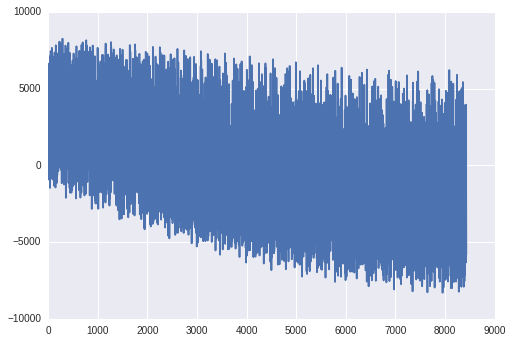

In [28]:
print idxs4
print idxs5
#print sorted(idxs4- idxs5)
plt.plot(idxs4-idxs5)

In [29]:
vals1 = {tuple(row) for row in loo_gp._x}
vals2 = {tuple(row) for row in t_x[:N-1]}
print vals1-vals2, len(vals1), len(vals2)

set([]) 8431 8431


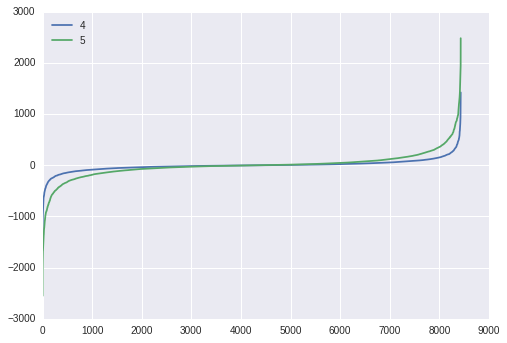

In [30]:
plt.plot(sorted(alpha4), label = '4')
plt.plot(sorted(alpha5), label = '5')
plt.legend(loc='best')
plt.show()

In [31]:
print loo_gp.predict(emu.y[1:], emu.x[0].reshape((1,emu.x.shape[1])), mean_only=True)

[ 3.81843655]


In [32]:
print emu.x[0].reshape((1,emu.x.shape[1]))
print loo_gp.parse_samples(emu.x[0].reshape((1,emu.x.shape[1])))[0]
print
#print emu.x[1:]
Kxxs4 = loo_gp.kernel.value(emu.x[0].reshape((1,emu.x.shape[1])), emu.x[1:])[0,:]
print Kxxs4
print
loo_gp._compute_alpha(emu.y[1:])
alpha4 = loo_gp._alpha
print alpha4
print
print np.dot(Kxxs4, alpha4) + loo_gp.mean(emu.x[0].reshape((1,emu.x.shape[1])))
print 

[[ 12.393        0.36        12.387       13.203        0.888        0.288
   -1.02809403]]
[[ 12.393        0.36        12.387       13.203        0.888        0.288
   -1.02809403]]

[  1.62389000e-01   2.18101533e-02   2.65943155e-03 ...,   1.56629775e-30
   2.82796230e-34   2.96673444e-38]

[-26.68531883  45.08125409   0.52031506 ...,   2.5735441    0.14753414
  -2.73712473]

[ 332.79046395]



In [33]:
print emu.x[0].reshape((1,emu.x.shape[1]))
print loo_gp.parse_samples(emu.x[0].reshape((1,emu.x.shape[1])), True)[0]
print
#print loo_gp._x
Kxxs4 = loo_gp.kernel.value(emu.x[0].reshape((1,emu.x.shape[1])), loo_gp._x)[0,:]
print Kxxs4
print
loo_gp._compute_alpha(emu.y[1:])
alpha4 = loo_gp._alpha
print alpha4
print
print np.dot(Kxxs4, alpha4) + loo_gp.mean(emu.x[0].reshape((1,emu.x.shape[1])))
print 

[[ 12.393        0.36        12.387       13.203        0.888        0.288
   -1.02809403]]
[ 12.393        0.36        12.387       13.203        0.888        0.288
  -1.02809403]

[  1.62389000e-01   2.18101533e-02   9.72302183e-02 ...,   1.58935305e-38
   2.06217077e-39   1.55409809e-39]

[-26.68531883  45.08125409   0.52031506 ...,   2.5735441    0.14753414
  -2.73712473]

[ 3.81843655]



In [34]:
print loo_gp._x
print
print emu.x[1:]
print 
xx = loo_gp.parse_samples(emu.x[1:], True)[0]
print xx

[[ 12.393        0.36        12.387      ...,   0.888        0.288
   -0.73335719]
 [ 12.393        0.36        12.387      ...,   0.888        0.288
   -0.53062108]
 [ 12.471        0.585       12.375      ...,   0.798        0.208
   -0.73335719]
 ..., 
 [ 11.91         0.672       10.018      ...,   1.086        0.33
    1.53253681]
 [ 11.74         0.548       10.144      ...,   1.152        0.321
    1.53253681]
 [ 11.856        0.643       10.084      ...,   1.118        0.474
    1.53253681]]

[[ 12.393        0.36        12.387      ...,   0.888        0.288
   -0.73335719]
 [ 12.393        0.36        12.387      ...,   0.888        0.288
   -0.53062108]
 [ 12.393        0.36        12.387      ...,   0.888        0.288
   -0.38325266]
 ..., 
 [ 11.815        0.243       11.184      ...,   1.097        0.13
    1.23779997]
 [ 11.815        0.243       11.184      ...,   1.097        0.13
    1.38516839]
 [ 11.815        0.243       11.184      ...,   1.097        0.13
    1.53

In [35]:
print loo_inv[0,:]
print 
print loo_inv[1,:]

[  1.96564257e+02  -2.74440036e+02  -4.17402233e+01 ...,   4.86810266e-03
   4.65590985e-03  -4.36067291e-03]

[ -2.74440036e+02   7.61615949e+02   6.14895863e+01 ...,  -1.88435473e-02
  -2.50623516e-02   2.21037310e-02]


In [36]:
mu = mu.reshape((-1,2))
loo_mu = loo_mu.reshape((-1,2))
mu2 = mu2.reshape((-1,2))

NameError: name 'mu2' is not defined

In [ ]:
fig = plt.figure(figsize = (10, 10))

for label, lxp,looxp, lxp2, c in zip(y_vals, mu,loo_mu, mu2,colors):
    plt.plot(10**rpoints[:2], lxp,label = '%.3f'%label, color = c, marker ='o')
    plt.plot(10**rpoints[:2], looxp, color = c, marker ='v')
    plt.plot(10**rpoints[:2], lxp2, color = c, marker ='^')
    

#plt.xlim(xmin = 0.08, xmax = .6)    
#plt.ylim(ymin = 2, ymax = 4)
#plt.title("OR Emulator w.r.t. %s"%y_param, fontsize =20)
#plt.loglog()
plt.xscale('log')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$r $  $\rm{[Mpc]}$', fontsize=25)
plt.ylabel(r'$\log_{10}{\xi_{\rm gg}(r) }$', fontsize=25)
plt.legend(loc='best', fontsize=25)

In [ ]:
(N - 1) / N * np.cov(mus, rowvar=False)